In [55]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [56]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import stats
from scipy import mean
from sklearn import model_selection
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import svm
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer   
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV

# Data loading functions
from brats.load_data import load_data 


In [57]:
# Functions

def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

def extract_info(data):
  # Print number of samples and columns (=number of features + 1)
  print(f'The number of samples: {len(data.index)}')
  print(f'The number of columns: {len(data.columns)}')
  print('')

  # Renaming the labels
  data = data.replace("GBM", 1)
  data = data.replace("LGG", 0)
  
  # Adjust data (replace infinity, #DIV/0 and 0 by NaN)
  data = data.replace([np.inf, -np.inf], np.nan)
  data = data.replace("#DIV/0!", np.nan)
  data = data.replace('nan', np.nan)

  # Remove ID index and replace by new index increasing from 1 to N
  data = data.reset_index()
  data = data.drop(columns=["ID"])

  X = data.drop(columns=["label"])
  Y = data.label

  return data, X, Y

def split_data(X, Y):
  X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=False)
  print(f'{len(Y_test)} are in test group')
  print(f'{len(Y_train)} are in train group')
  print('')

  return X_train, X_test, Y_train, Y_test

def exclude_outliers(data):
  # Exclude outliers
  data.mask(data.sub(data.mean()).div(data.std()).abs().gt(2))

  return data

def exclude_features(X):
  # Search for features with >60% missing data (NaN values)
  missing = X.isnull().sum(axis = 0).reset_index()
  missing.columns = ['column_name', 'missing_count']
  missing = missing.loc[missing['missing_count']>(0.6*len(X.index))] 
  print(f'The number of features that have more than 60% missing data is {missing.shape[0]}. The following features are removed:')
  print(missing)

  # Remove features >60% missing data (NaN values)
  X = X.drop(missing['column_name'], axis=1, inplace=False)
  features=list(X.columns)
  print(f'The data now has {len(features)} features')
  print('')

  return X, features, missing

def exclude_features2(X):
  missing = X.isnull().sum(axis = 0).reset_index()
  missing.columns = ['column_name', 'missing_count']
  missing = missing.loc[missing['missing_count']>(0.6*len(X.index))] 
  X = X.drop(missing['column_name'], axis=1, inplace=False)
  features=list(X.columns)
  return X, features, missing

def PCA_impl(X_train):
  pca = PCA(0.95).fit(X_train)
  fig2, ax2 = plt.subplots(2,1, figsize=(15,10))
  ax2[0].plot(np.cumsum(pca.explained_variance_ratio_))
  ax2[0].set_title('Prinicpal Component Analysis')
  ax2[0].set_xlabel('Number of components')
  ax2[0].set_ylabel('Cumulative explained variance')

  pca = PCA(0.95)
  pca.fit(X_train)
  X_pca = pca.transform(X_train)
  print(f'95% of the usefull features: {pca.n_components_}')
  X_all_pca = X_pca[:,:]
  X_2pca = X_pca[:, [0, 3]]

  per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
  labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

  ax2[1].bar(x=range(1,len(per_var)+1), height = per_var, tick_label = labels)
  ax2[1].set_ylabel('Percentage of explaned variance')
  ax2[1].set_xlabel('Principal component')
  ax2[1].tick_params(labelrotation=90)
  ax2[1].set_title('Scree plot')

  return X_all_pca, X_2pca, pca

def mean_std(all_train, all_val):
  all_train = np.array(all_train)
  all_val = np.array(all_val)
  train_scores_mean = all_train.mean(axis=0)
  train_scores_std = all_train.std(axis=0)
  val_scores_mean = all_val.mean(axis=0)
  val_scores_std = all_val.std(axis=0)

  return all_train, all_val, train_scores_mean, train_scores_std, val_scores_mean, val_scores_std

The number of samples: 167
The number of columns: 725

34 are in test group
133 are in train group



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


The number of features that have more than 60% missing data is 20. The following features are removed:
     column_name  missing_count
704          704            106
705          705            106
706          706            106
707          707            106
708          708            125
709          709            125
710          710            125
711          711            125
712          712            130
713          713            130
714          714            130
715          715            130
716          716            130
717          717            130
718          718            130
719          719            130
720          720            132
721          721            132
722          722            132
723          723            132
The data now has 704 features

95% of the usefull features: 68


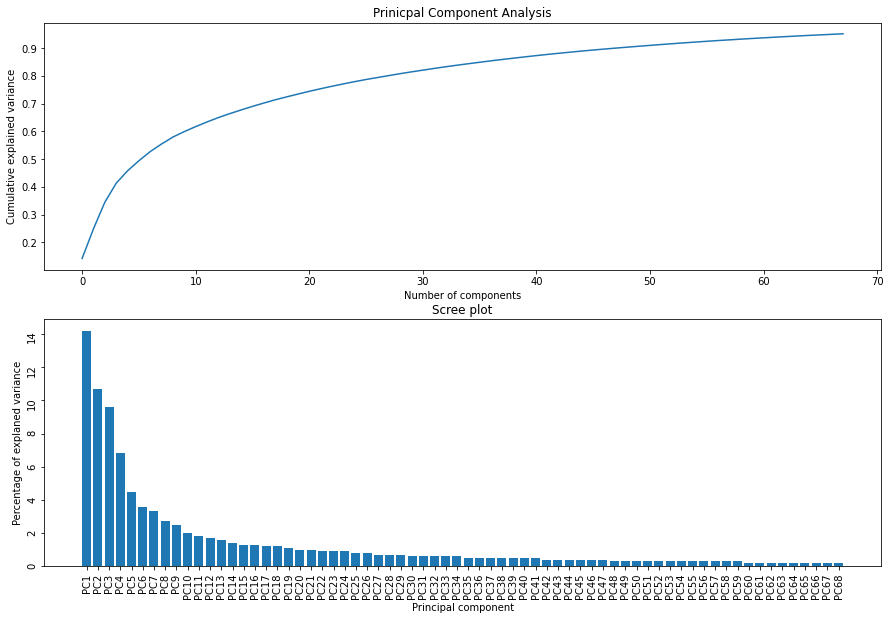

In [73]:
## Loading and adjusting data, PCA implementation

# Load data
data =  load_data()
features=list(data.columns)

# Split data
data, X, Y = extract_info(data)
X_train, X_test, Y_train, Y_test = split_data(X, Y)

# Adjust data 
X_adjust_train = exclude_outliers(X_train)

# Extract info (number of samples and features (columns)) & scale data
scaler = preprocessing.StandardScaler()
data_scaled_train = scaler.fit_transform(X_adjust_train)
data_scaled_train = pd.DataFrame(data_scaled_train)

# Exclude features with more than 60% missing
X_exclude, features, missing = exclude_features(data_scaled_train)

# Fill in missing data
imputer_knn = KNNImputer(n_neighbors=7)
X_imp_train = imputer_knn.fit_transform(X_exclude)

X_train = np.array(X_imp_train)
Y_train = np.array(Y_train)

# PCA implementation
X_train_all_pca, X_train_2pca, pca = PCA_impl(X_train)

ROC Curves and AUC score for all classifiers

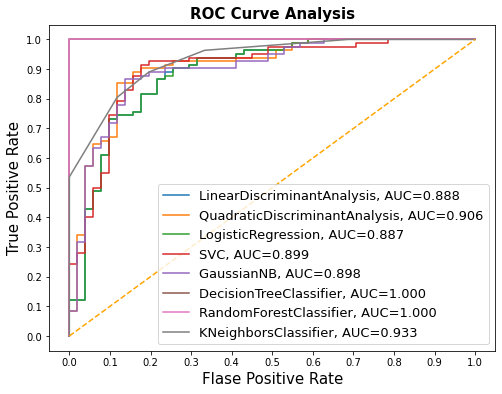

In [77]:
# Instantiate the classfiers and make a list

clsfs = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
         LogisticRegression(), SVC(probability=True), GaussianNB(),
         DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in clsfs:
    model = cls.fit(X_train_2pca, Y_train)
    yproba = model.predict_proba(X_train_2pca)[::,1]
    
    fpr, tpr, _ = roc_curve(Y_train, yproba)
    auc = roc_auc_score(Y_train, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Find hyperparameters

Text(0.5, 0, 'Max depth ')

<Figure size 432x288 with 0 Axes>

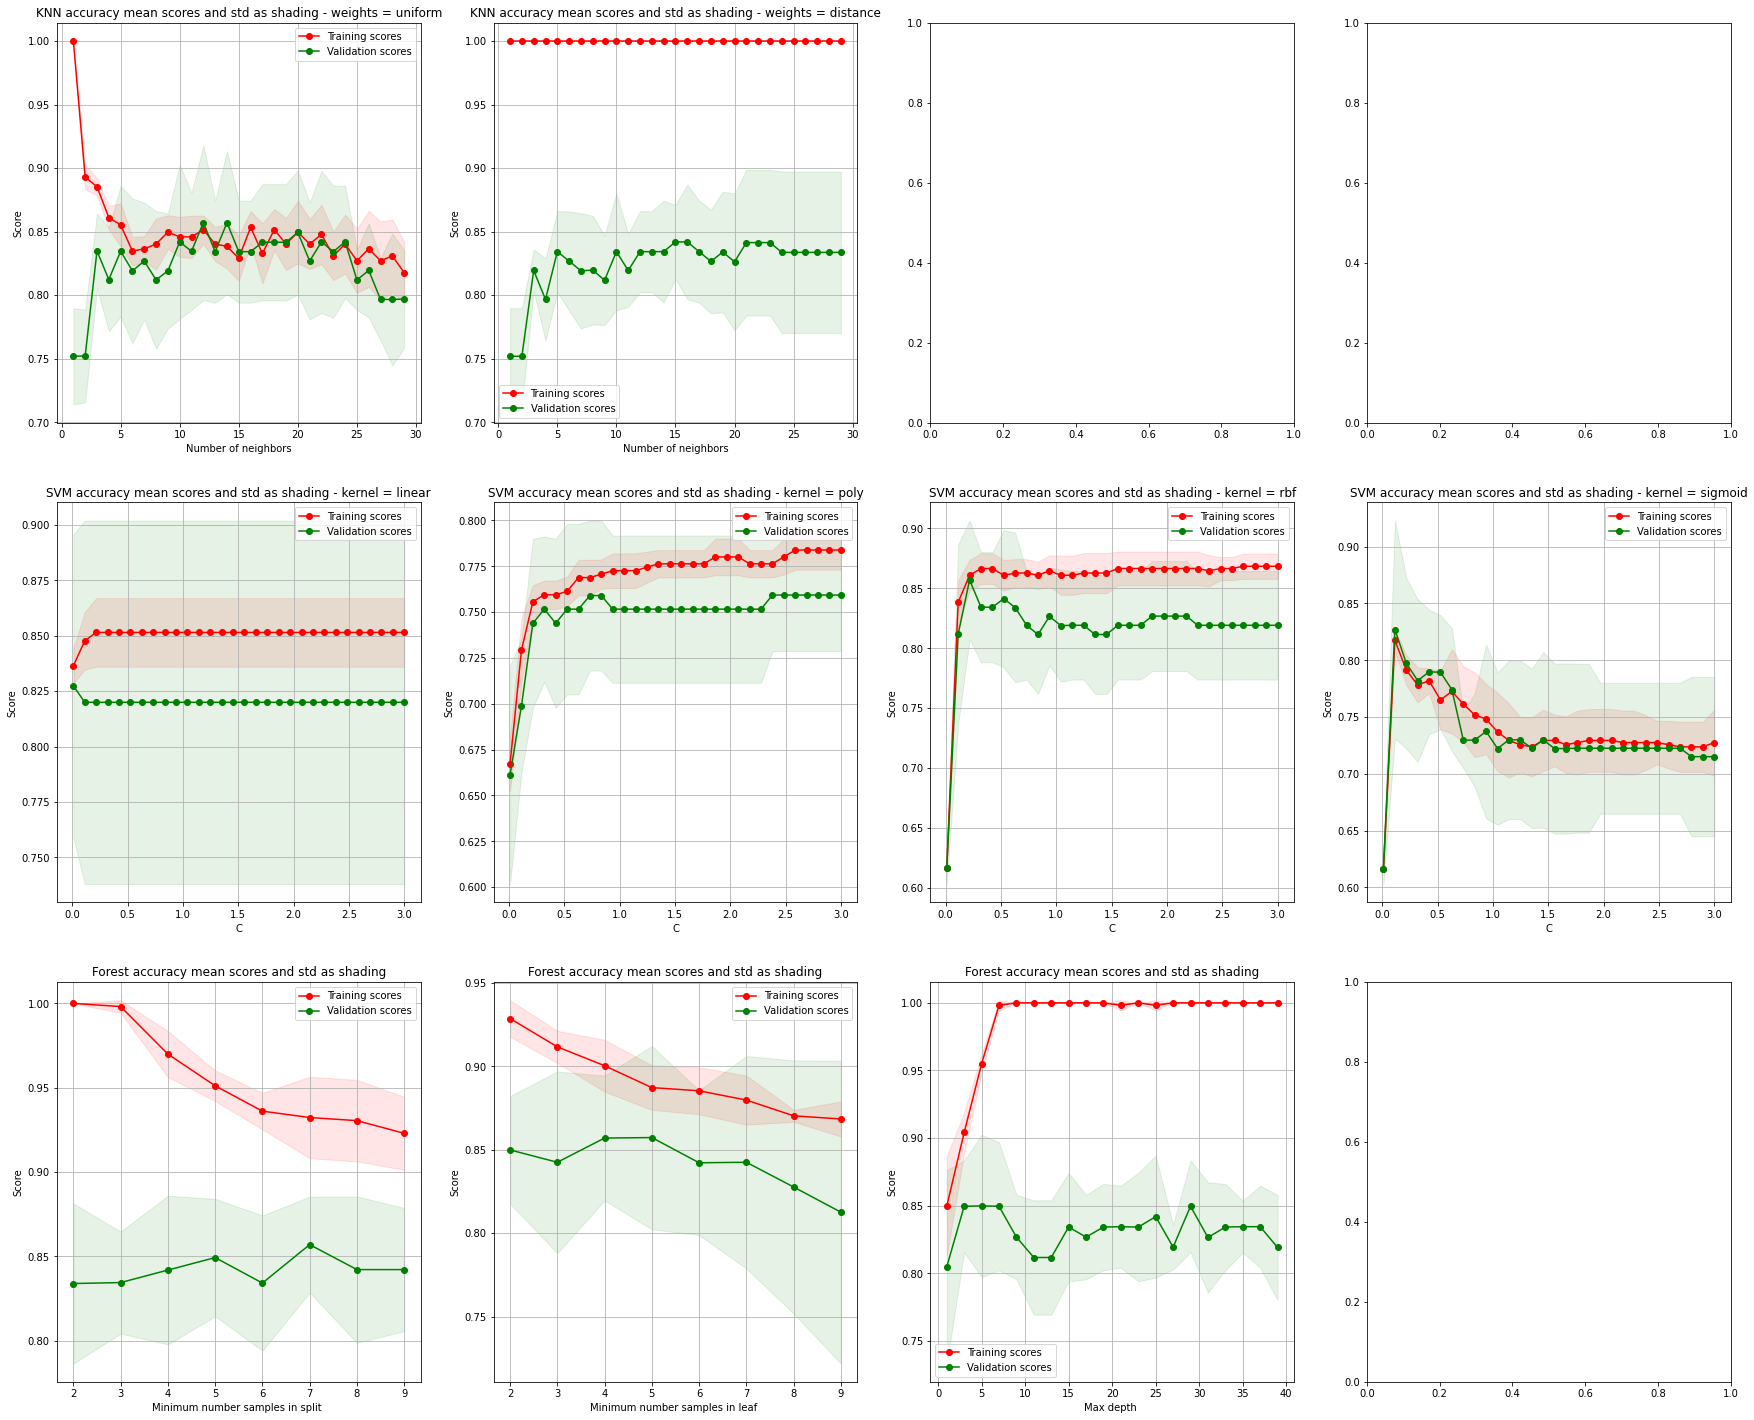

In [60]:
# Eventually this was not used, because we used a random hyperparameter search

cv_5fold = model_selection.StratifiedKFold(n_splits=5, random_state=None)
k_list = list(range(1,30,1))
c_list = list(np.linspace(0.01,3,30))
f_list = list(range(2,10,1))
f2_list = list(range(2,10,1))
f3_list = list(range(1,40,2))
all_train_knn = []
all_val_knn = []
all_train_knn2 = []
all_val_knn2 = []
all_train_svm = []
all_val_svm = []
all_train_svm2 = []
all_val_svm2 = []
all_train_svm3 = []
all_val_svm3 = []
all_train_svm4 = []
all_val_svm4 = []
all_train_forest = []
all_val_forest = []
all_train_forest2 = []
all_val_forest2 = []
all_train_forest3 = []
all_val_forest3 = []

clfs_fit = []

Xt=list()
Yt=list()
fold = 1

for train_index, val_index in cv_5fold.split(X_train_2pca, Y_train):
  # Split the data
  X_train_train = X_train_2pca[train_index]
  Y_train_train = Y_train[train_index]
  X_train_val = X_train_2pca[val_index]
  Y_train_val = Y_train[val_index]

  train_scores_knn = []
  val_scores_knn = []
  train_scores_knn2 = []
  val_scores_knn2 = []
  train_scores_knn3 = []
  val_scores_knn3 = []
  train_scores_svm = []
  val_scores_svm = []
  train_scores_svm2 = []
  val_scores_svm2 = []
  train_scores_svm3 = []
  val_scores_svm3 = []
  train_scores_svm4 = []
  val_scores_svm4 = []
  train_scores_svm5 = []
  val_scores_svm5 = []
  train_scores_forest = []
  val_scores_forest = []
  train_scores_forest2 = []
  val_scores_forest2 = []
  train_scores_forest3 = []
  val_scores_forest3 = []

  all_auc = []
  all_accuracy = []
  all_F1 = []
  all_precision = []
  all_recall = []

  for k in k_list:
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    clf_knn.fit(X_train_train, Y_train_train)

    # Test the KNN classifier on the training data and plot
    score_train_knn = clf_knn.score(X_train_train, Y_train_train)
    score_val_knn = clf_knn.score(X_train_val, Y_train_val)

    train_scores_knn.append(score_train_knn)
    val_scores_knn.append(score_val_knn)
  
  for k in k_list:
    clf_knn2 = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
    clf_knn2.fit(X_train_train, Y_train_train)

    # Test the KNN classifier on the training data and plot
    score_train_knn2 = clf_knn2.score(X_train_train, Y_train_train)
    score_val_knn2 = clf_knn2.score(X_train_val, Y_train_val)

    train_scores_knn2.append(score_train_knn2)
    val_scores_knn2.append(score_val_knn2)

  for c in c_list:
    clf_svm = svm.SVC(C=c, kernel='linear')
    clf_svm.fit(X_train_train, Y_train_train)

    # Test the classifier on the training data and plot
    score_train_svm = clf_svm.score(X_train_train, Y_train_train)
    score_val_svm = clf_svm.score(X_train_val, Y_train_val)

    train_scores_svm.append(score_train_svm)
    val_scores_svm.append(score_val_svm)

  for c in c_list:
    clf_svm2 = svm.SVC(C=c, kernel='poly')
    clf_svm2.fit(X_train_train, Y_train_train)

    # Test the classifier on the training data and plot
    score_train_svm2 = clf_svm2.score(X_train_train, Y_train_train)
    score_val_svm2 = clf_svm2.score(X_train_val, Y_train_val)

    train_scores_svm2.append(score_train_svm2)
    val_scores_svm2.append(score_val_svm2)

  for c in c_list:
    clf_svm3 = svm.SVC(C=c, kernel='rbf')
    clf_svm3.fit(X_train_train, Y_train_train)

    # Test the classifier on the training data and plot
    score_train_svm3 = clf_svm3.score(X_train_train, Y_train_train)
    score_val_svm3 = clf_svm3.score(X_train_val, Y_train_val)

    train_scores_svm3.append(score_train_svm3)
    val_scores_svm3.append(score_val_svm3)

  for c in c_list:
    clf_svm4 = svm.SVC(C=c, kernel='sigmoid')
    clf_svm4.fit(X_train_train, Y_train_train)

    # Test the classifier on the training data and plot
    score_train_svm4 = clf_svm4.score(X_train_train, Y_train_train)
    score_val_svm4 = clf_svm4.score(X_train_val, Y_train_val)

    train_scores_svm4.append(score_train_svm4)
    val_scores_svm4.append(score_val_svm4)

  for f in f_list:
    clf_forest = RandomForestClassifier(min_samples_split=f)
    clf_forest.fit(X_train_train, Y_train_train)

    # Test the classifier on the training data and plot
    score_train_forest = clf_forest.score(X_train_train, Y_train_train)
    score_val_forest = clf_forest.score(X_train_val, Y_train_val)
    train_scores_forest.append(score_train_forest)
    val_scores_forest.append(score_val_forest)
  
  for f in f2_list:
    clf_forest2 = RandomForestClassifier(min_samples_leaf=f)
    clf_forest2.fit(X_train_train, Y_train_train)

    # Test the classifier on the training data and plot
    score_train_forest2 = clf_forest2.score(X_train_train, Y_train_train)
    score_val_forest2 = clf_forest2.score(X_train_val, Y_train_val)
    train_scores_forest2.append(score_train_forest2)
    val_scores_forest2.append(score_val_forest2)

  for f in f3_list:
    clf_forest3 = RandomForestClassifier(max_depth=f)
    clf_forest3.fit(X_train_train, Y_train_train)

    # Test the classifier on the training data and plot
    score_train_forest3 = clf_forest3.score(X_train_train, Y_train_train)
    score_val_forest3 = clf_forest3.score(X_train_val, Y_train_val)
    train_scores_forest3.append(score_train_forest3)
    val_scores_forest3.append(score_val_forest3)

  all_train_knn.append(train_scores_knn)
  all_val_knn.append(val_scores_knn)
  all_train_knn2.append(train_scores_knn2)
  all_val_knn2.append(val_scores_knn2)

  all_train_svm.append(train_scores_svm)
  all_val_svm.append(val_scores_svm)
  all_train_svm2.append(train_scores_svm2)
  all_val_svm2.append(val_scores_svm2)
  all_train_svm3.append(train_scores_svm3)
  all_val_svm3.append(val_scores_svm3)
  all_train_svm4.append(train_scores_svm4)
  all_val_svm4.append(val_scores_svm4)

  all_train_forest.append(train_scores_forest)
  all_val_forest.append(val_scores_forest)
  all_train_forest2.append(train_scores_forest2)
  all_val_forest2.append(val_scores_forest2)
  all_train_forest3.append(train_scores_forest3)
  all_val_forest3.append(val_scores_forest3)

all_train_knn, all_val_knn, train_scores_mean_knn, train_scores_std_knn, val_scores_mean_knn, val_scores_std_knn = mean_std(all_train_knn, all_val_knn)
all_train_knn2, all_val_knn2, train_scores_mean_knn2, train_scores_std_knn2, val_scores_mean_knn2, val_scores_std_knn2 = mean_std(all_train_knn2, all_val_knn2)
all_train_svm, all_val_svm, train_scores_mean_svm, train_scores_std_svm, val_scores_mean_svm, val_scores_std_svm = mean_std(all_train_svm, all_val_svm)
all_train_svm2, all_val_svm2, train_scores_mean_svm2, train_scores_std_svm2, val_scores_mean_svm2, val_scores_std_svm2 = mean_std(all_train_svm2, all_val_svm2)
all_train_svm3, all_val_svm3, train_scores_mean_svm3, train_scores_std_svm3, val_scores_mean_svm3, val_scores_std_svm3 = mean_std(all_train_svm3, all_val_svm3)
all_train_svm4, all_val_svm4, train_scores_mean_svm4, train_scores_std_svm4, val_scores_mean_svm4, val_scores_std_svm4 = mean_std(all_train_svm4, all_val_svm4)
all_train_forest, all_val_forest, train_scores_mean_forest, train_scores_std_forest, val_scores_mean_forest, val_scores_std_forest = mean_std(all_train_forest, all_val_forest)
all_train_forest2, all_val_forest2, train_scores_mean_forest2, train_scores_std_forest2, val_scores_mean_forest2, val_scores_std_forest2 = mean_std(all_train_forest2, all_val_forest2)
all_train_forest3, all_val_forest3, train_scores_mean_forest3, train_scores_std_forest3, val_scores_mean_forest3, val_scores_std_forest3 = mean_std(all_train_forest3, all_val_forest3)

# Plot the mean scores and the std as shading of KNN - weights = uniform
fig = plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(30,25))
ax[0,0].set_title('KNN accuracy mean scores and std as shading - weights = uniform')
ax[0,0].grid()
ax[0,0].fill_between(k_list, train_scores_mean_knn - train_scores_std_knn,
                     train_scores_mean_knn + train_scores_std_knn, alpha=0.1,
                     color="r")
ax[0,0].fill_between(k_list, val_scores_mean_knn - val_scores_std_knn,
                     val_scores_mean_knn + val_scores_std_knn, alpha=0.1,
                     color="g")
ax[0,0].plot(k_list, train_scores_mean_knn, 'o-', color="r",
        label="Training score")
ax[0,0].plot(k_list, val_scores_mean_knn, 'o-', color="g",
        label="Test score")
ax[0,0].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[0,0].set_ylabel('Score')
ax[0,0].set_xlabel('Number of neighbors')

# Plot the mean scores and the std as shading of KNN - weights = distance
ax[0,1].set_title('KNN accuracy mean scores and std as shading - weights = distance')
ax[0,1].grid()
ax[0,1].fill_between(k_list, train_scores_mean_knn2 - train_scores_std_knn2,
                     train_scores_mean_knn2 + train_scores_std_knn2, alpha=0.1,
                     color="r")
ax[0,1].fill_between(k_list, val_scores_mean_knn2 - val_scores_std_knn2,
                     val_scores_mean_knn2 + val_scores_std_knn2, alpha=0.1,
                     color="g")
ax[0,1].plot(k_list, train_scores_mean_knn2, 'o-', color="r",
        label="Training score")
ax[0,1].plot(k_list, val_scores_mean_knn2, 'o-', color="g",
        label="Test score")
ax[0,1].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[0,1].set_ylabel('Score')
ax[0,1].set_xlabel('Number of neighbors')

# Plot the mean scores and the std as shading of SVM
ax[1,0].set_title('SVM accuracy mean scores and std as shading - kernel = linear')
ax[1,0].grid()
ax[1,0].fill_between(c_list, train_scores_mean_svm - train_scores_std_svm,
                     train_scores_mean_svm + train_scores_std_svm, alpha=0.1,
                     color="r")
ax[1,0].fill_between(c_list, val_scores_mean_svm - val_scores_std_svm,
                     val_scores_mean_svm + val_scores_std_svm, alpha=0.1,
                     color="g")
ax[1,0].plot(c_list, train_scores_mean_svm, 'o-', color="r",
        label="Training score")
ax[1,0].plot(c_list, val_scores_mean_svm, 'o-', color="g",
        label="Test score")
ax[1,0].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[1,0].set_ylabel('Score')
ax[1,0].set_xlabel('C')

# Plot the mean scores and the std as shading of SVM
ax[1,1].set_title('SVM accuracy mean scores and std as shading - kernel = poly')
ax[1,1].grid()
ax[1,1].fill_between(c_list, train_scores_mean_svm2 - train_scores_std_svm2,
                     train_scores_mean_svm2 + train_scores_std_svm2, alpha=0.1,
                     color="r")
ax[1,1].fill_between(c_list, val_scores_mean_svm2 - val_scores_std_svm2,
                     val_scores_mean_svm2 + val_scores_std_svm2, alpha=0.1,
                     color="g")
ax[1,1].plot(c_list, train_scores_mean_svm2, 'o-', color="r",
        label="Training score")
ax[1,1].plot(c_list, val_scores_mean_svm2, 'o-', color="g",
        label="Test score")
ax[1,1].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[1,1].set_ylabel('Score')
ax[1,1].set_xlabel('C')

# Plot the mean scores and the std as shading of SVM
ax[1,2].set_title('SVM accuracy mean scores and std as shading - kernel = rbf')
ax[1,2].grid()
ax[1,2].fill_between(c_list, train_scores_mean_svm3 - train_scores_std_svm3,
                     train_scores_mean_svm3 + train_scores_std_svm3, alpha=0.1,
                     color="r")
ax[1,2].fill_between(c_list, val_scores_mean_svm3 - val_scores_std_svm3,
                     val_scores_mean_svm3 + val_scores_std_svm3, alpha=0.1,
                     color="g")
ax[1,2].plot(c_list, train_scores_mean_svm3, 'o-', color="r",
        label="Training score")
ax[1,2].plot(c_list, val_scores_mean_svm3, 'o-', color="g",
        label="Test score")
ax[1,2].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[1,2].set_ylabel('Score')
ax[1,2].set_xlabel('C')

# Plot the mean scores and the std as shading of SVM
ax[1,3].set_title('SVM accuracy mean scores and std as shading - kernel = sigmoid')
ax[1,3].grid()
ax[1,3].fill_between(c_list, train_scores_mean_svm4 - train_scores_std_svm4,
                     train_scores_mean_svm4 + train_scores_std_svm4, alpha=0.1,
                     color="r")
ax[1,3].fill_between(c_list, val_scores_mean_svm4 - val_scores_std_svm4,
                     val_scores_mean_svm4 + val_scores_std_svm4, alpha=0.1,
                     color="g")
ax[1,3].plot(c_list, train_scores_mean_svm4, 'o-', color="r",
        label="Training score")
ax[1,3].plot(c_list, val_scores_mean_svm4, 'o-', color="g",
        label="Test score")
ax[1,3].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[1,3].set_ylabel('Score')
ax[1,3].set_xlabel('C')

# Plot the mean scores and the std as shading of Forest clf - min samples in split
ax[2,0].set_title('Forest accuracy mean scores and std as shading')
ax[2,0].grid()
ax[2,0].fill_between(f_list, train_scores_mean_forest - train_scores_std_forest,
                     train_scores_mean_forest + train_scores_std_forest, alpha=0.1,
                     color="r")
ax[2,0].fill_between(f_list, val_scores_mean_forest - val_scores_std_forest,
                     val_scores_mean_forest + val_scores_std_forest, alpha=0.1,
                     color="g")
ax[2,0].plot(f_list, train_scores_mean_forest, 'o-', color="r",
        label="Training score")
ax[2,0].plot(f_list, val_scores_mean_forest, 'o-', color="g",
        label="Test score")
ax[2,0].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[2,0].set_ylabel('Score')
ax[2,0].set_xlabel('Minimum number samples in split ')

# Plot the mean scores and the std as shading of Forest clf - min samples in leaf
ax[2,1].set_title('Forest accuracy mean scores and std as shading')
ax[2,1].grid()
ax[2,1].fill_between(f2_list, train_scores_mean_forest2 - train_scores_std_forest2,
                     train_scores_mean_forest2 + train_scores_std_forest2, alpha=0.1,
                     color="r")
ax[2,1].fill_between(f2_list, val_scores_mean_forest2 - val_scores_std_forest2,
                     val_scores_mean_forest2 + val_scores_std_forest2, alpha=0.1,
                     color="g")
ax[2,1].plot(f2_list, train_scores_mean_forest2, 'o-', color="r",
        label="Training score")
ax[2,1].plot(f2_list, val_scores_mean_forest2, 'o-', color="g",
        label="Test score")
ax[2,1].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[2,1].set_ylabel('Score')
ax[2,1].set_xlabel('Minimum number samples in leaf ')

# Plot the mean scores and the std as shading of Forest clf - max depth
ax[2,2].set_title('Forest accuracy mean scores and std as shading')
ax[2,2].grid()
ax[2,2].fill_between(f3_list, train_scores_mean_forest3 - train_scores_std_forest3,
                     train_scores_mean_forest3 + train_scores_std_forest3, alpha=0.1,
                     color="r")
ax[2,2].fill_between(f3_list, val_scores_mean_forest3 - val_scores_std_forest3,
                     val_scores_mean_forest3 + val_scores_std_forest3, alpha=0.1,
                     color="g")
ax[2,2].plot(f3_list, train_scores_mean_forest3, 'o-', color="r",
        label="Training score")
ax[2,2].plot(f3_list, val_scores_mean_forest3, 'o-', color="g",
        label="Test score")
ax[2,2].legend(['Training scores', 'Validation scores'], loc = 'best')
ax[2,2].set_ylabel('Score')
ax[2,2].set_xlabel('Max depth ')


Hyperparameter optimization with random search

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC as svc
import scipy

# Random search KNN classifier
knn_dist = {}
knn_dist["n_neighbors"] = list(range(1, 31))
knn_dist["weights"] = ['uniform', 'distance']
knn_dist["algorithm"] = ['auto', 'ball_tree', 'kd_tree', 'brute']

knn = KNeighborsClassifier()
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = knn_dist, 
                               n_iter = 100, cv = 5, verbose=2, random_state=False, n_jobs = -1, scoring='roc_auc')
knn_random.fit(X_train_2pca,Y_train)
print('Best roc auc KNN: ', knn_random.best_score_)
print('Best parameters KNN: ', knn_random.best_params_, '\n')

# Quadratic Discriminant Analysis: not possible
# GaussianNB: not possible

# Random search Logistic regression classifier 
lr_dist = {}
lr_dist["C"] = scipy.stats.expon(scale=.01)
lr_dist["fit_intercept"] =  [True, False]
lr_dist["warm_start"] = [True,False]
lr_dist["random_state"] = [False]

lr = LogisticRegression()
lr_random = RandomizedSearchCV(estimator=lr, param_distributions = lr_dist, n_iter = 100, 
                               cv = 5, verbose=2, random_state=False, n_jobs = -1, scoring='roc_auc') 
lr_random.fit(X_train_2pca,Y_train)
print('Best roc auc Logistic Regression: ', lr_random.best_score_)
print('Best parameters Logistic Regression: ', lr_random.best_params_, '\n')

# Random search Random Forest classifier
rf_dist = {}
rf_dist["n_estimators"] = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
rf_dist["max_features"] = ['auto', 'sqrt']
rf_dist["max_depth"] = [int(x) for x in np.linspace(10, 120, num = 12)]
rf_dist["min_samples_split"] = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rf_dist["min_samples_leaf"] = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rf_dist["bootstrap"] = [True, False]

rf = RandomForestRegressor(random_state = False)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_dist, 
                               n_iter = 100, cv = 5, verbose=2, random_state=False, n_jobs = -1, scoring='roc_auc')
rf_random.fit(X_train_2pca,Y_train)
print('Best roc auc RF: ', rf_random.best_score_)
print('Best Parameters Random Forest: ', rf_random.best_params_, ' \n')

# Random search SVM classifier
SVM_dist = {}
SVM_dist["C"] = stats.uniform(2, 10)
SVM_dist["gamma"] = stats.uniform(0.1, 1)
SVM_dist['kernel'] = ['linear']
#SVM_dist["kernel"] = ["linear", "poly", "rbf", "sigmoid"]

mdl = svm.SVC(probability = True, random_state = False)              
SVM_random = RandomizedSearchCV(estimator=mdl, param_distributions = SVM_dist, n_iter = 100, 
                                  n_jobs = -1, cv = 5, random_state = False, scoring='roc_auc')
SVM_random.fit(X_train_2pca, Y_train)
print('Best roc auc SVM - linear kernel: ', SVM_random.best_score_)
print('Best Parameters SVM - linear kernel: ', SVM_random.best_params_, '\n')

# SVM kernel 'poly' was not used because of very long runtimes

SVM_dist3 = {}
SVM_dist3["C"] = stats.uniform(2, 10)
SVM_dist3["gamma"] = stats.uniform(0.1, 1)
SVM_dist3['kernel'] = ['rbf']
          
SVM_random = RandomizedSearchCV(estimator=mdl, param_distributions = SVM_dist3, n_iter = 100, 
                                  n_jobs = -1, cv = 5, random_state = False, scoring='roc_auc')
SVM_random.fit(X_train_2pca, Y_train)
print('Best roc auc SVM - rbf kernel: ', SVM_random.best_score_)
print('Best Parameters SVM - rbf kernel: ', SVM_random.best_params_, '\n')

SVM_dist4 = {}
SVM_dist4["C"] = stats.uniform(2, 10)
SVM_dist4["gamma"] = stats.uniform(0.1, 1)
SVM_dist4['kernel'] = ['sigmoid']
          
SVM_random = RandomizedSearchCV(estimator=mdl, param_distributions = SVM_dist4, n_iter = 100, 
                                  n_jobs = -1, cv = 5, random_state = False, scoring='roc_auc')
SVM_random.fit(X_train_2pca, Y_train)
print('Best roc auc SVM - sigmoid kernel: ', SVM_random.best_score_)
print('Best Parameters SVM - sigmoid kernel: ', SVM_random.best_params_, '\n')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best roc auc KNN:  0.9186497326203209
Best parameters KNN:  {'weights': 'uniform', 'n_neighbors': 19, 'algorithm': 'kd_tree'} 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best roc auc Logistic Regression:  0.889264705882353
Best parameters Logistic Regression:  {'C': 0.0021888060270504055, 'fit_intercept': True, 'random_state': False, 'warm_start': False} 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best roc auc RF:  0.9136655011655013
Best Parameters Random Forest:  {'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}  

Best roc auc SVM - linear kernel:  0.8733890374331551
Best Parameters SVM - linear kernel:  {'C': 7.4881350392732475, 'gamma': 0.8151893663724195, 'kernel': 'linear'} 

Best roc auc SVM - rbf kernel:  0.8058389037433156
Best Parameters SVM - rbf kernel:  {'C': 4.274146279733232, 'gamma': 0.35

Check on test set

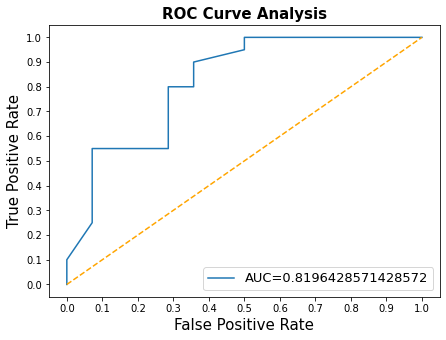

Text(0.5, 1.0, 'Classifier: KNeighborsClassifier(n_neighbors=27), Misclass: 9 / 34')

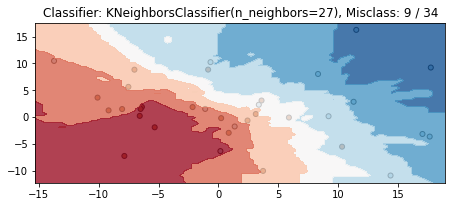

In [62]:
## Results test set

#### Preprocessing
# Adjust data 
#------- X_test = exclude_outliers(X_test)

# Extract info (number of samples and features (columns)) & scale data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Exclude features with more than 60% missing
#------ X_test_exclude, test_features, test_missing = exclude_features(X_test_scaled)
X_test_exclude = X_test_scaled.drop(missing['column_name'], axis=1, inplace=False)

# Fill in missing data
#------ X_test_imp = imputer_knn(X_test_exclude)
X_test_imp = imputer_knn.transform(X_test_exclude)

X_test2 = np.array(X_test_imp)
Y_test2 = np.array(Y_test)

# PCA implementation
X_test2_2pca = pca.transform(X_test2)[:,[0,3]]
X_test2 = X_test2_2pca

#### Check classifier
clf_def = SVC(C=3.999965248964001, probability=True, gamma=0.11852179446061398, kernel='rbf')
clf_def = KNeighborsClassifier(weights='uniform', n_neighbors=27, algorithm='auto')

model = clf_def.fit(X_train_2pca, Y_train)
yproba = model.predict_proba(X_test2)[::,1]
y_pred=clf_def.predict(X_test2)
    
fpr, tpr, _ = roc_curve(Y_test, yproba)
auc = roc_auc_score(Y_test, yproba)
    
result_table = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'auc':auc})

### Plot results
fig = plt.figure(figsize=(7,5))

#for i in result_table.index:
plt.plot(result_table['fpr'], 
        result_table['tpr'], 
        label="AUC={}".format(result_table.iloc[1]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Colorplot
fig = plt.figure(figsize=(25,10))
num = 0  # Iteration number for the subplots
ax = fig.add_subplot(3, 3, 1)
ax.scatter(X_test2[:,0], X_test2[:,1], marker='o', c=Y_test,
          s=25, edgecolor='k', cmap=plt.cm.Paired)
colorplot(clf_def, ax, X_test2[:,0], X_test2[:,1])
ax.set_title("Classifier: %s, Misclass: %d / %d" % (clf_def, (Y_test!=y_pred).sum(), len(X_test)))



Cross validatie train & Test set


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is 

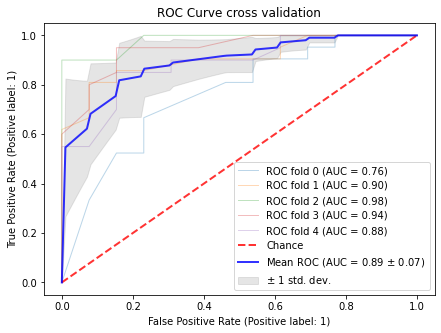

In [75]:
# Cross validation test set 
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# INPUT???
fig, ax = plt.subplots(figsize=[7,5])
for i, (train, test) in enumerate(cv.split(X, Y)):
  #preprocessing
  X_adjust = exclude_outliers(X)

  # Extract info (number of samples and features (columns)) & scale data
  X_scaled = scaler.transform(X_adjust)
  X_scaled = pd.DataFrame(X_scaled)

  # Exclude features with more than 60% missing
  X_exclude = X_scaled.drop(missing['column_name'], axis=1, inplace=False)

  # Fill in missing data
  X_imp = imputer_knn.transform(X_exclude)

  X2 = np.array(X_imp)
  Y2 = np.array(Y)

  # PCA implementation
  X_2pca = pca.transform(X2)[:,[0,3]]
  X2 = X_2pca

  clf_def.fit(X2[train], Y[train])
  viz = RocCurveDisplay.from_estimator(
        clf_def,
        X2[test],
        Y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
    )

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
    )

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC Curve cross validation",
    )
ax.legend(loc="lower right")
plt.show()